In [141]:
%matplotlib inline
import pandas as pd
import os
import seaborn as sns
from functools import reduce
sns.set()
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 100)


#  [{'io': 'school/'+s, 'header': 1, 'index_col':0} for s in os.listdir("school") if not s.startswith('.')]
kwargs =[{'header': 1, 'index_col': 0, 'io': 'school/enrollmentbygrade.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/enrollmentbygrade_school.xlsx'},
         {'header': 4, 'index_col': 0, 'io': 'school/enrollmentbyracegender.xlsx'},
         {'header': 4, 'index_col': 0, 'io': 'school/enrollmentbyracegender_school.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/ap_participation (1).xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/ap_participation.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/ap_performance (1).xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/ap_performance.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/ClassSizebyGenPopulation.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/dropout (1).xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/dropout.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/gradrates (1).xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/gradrates.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/Gradsattendingcollege (1).xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/Gradsattendingcollege.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/Gradsattendingcollege_school.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/mcas copy.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/mcas.xlsx'},
#          {'header': 1, 'index_col': 0, 'io': 'school/nonpublicschoolreport.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/PerPupilExpenditures.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/sat_performance copy.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/sat_performance.xlsx'},
         {'header':  [4,5], 'index_col': 0, 'io': 'school/selectedpopulations (1).xlsx'},
         {'header':  [4,5], 'index_col': 0, 'io': 'school/SelectedPopulations.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/ssdr.xlsx'},
         {'header': 2, 'index_col': 0, 'io': 'school/teacherdata (1).xlsx'},
         {'header': 2, 'index_col': 0, 'io': 'school/teacherdata.xlsx'},
         {'header': 1, 'index_col': 0, 'io': 'school/TeacherSalaries.xlsx'}]

schooldata = []
districtdata = []

def clean_name(idx):
    if idx.name=='DISTRICT' or (idx.name is None and len(idx) == 407):
        return "District Name"
    if idx.name == 'SCHOOL' or (idx.name is None and len(idx) == 1848):
        return "School Name"
    return idx.name

def clean_col(c):
    c = c.replace(' ', '').replace('%', "Percent").replace('-', '').replace('#', 'Num')
    return c.replace('(', '').replace(')', '').replace('/', '').replace('.','')

TODROP = ['OrgCode', 'ORGCODE', 'DistrictCode']
for kw in kwargs:
#     print(kw['io'])
    df = pd.read_excel(**kw)
    df.index.name = clean_name(df.index)

    if type(kw['header']) == list:
        df.columns = df.columns.map('{0[0]}{0[1]}'.format)
    # uncomment to check all column headers
    # print(df.columns)
    df.columns = [clean_col(c) for c in df.columns]

    if df.index.name == "District Name":
        for n in TODROP:
            if n in df.columns:
                df = df.drop(n, axis=1)
        districtdata.append(df)
    elif df.index.name == "School Name":
        schooldata.append(df)
    else:
        raise Exception("Unknown index name {}".format(df.index.name))
        

In [142]:
# split the index to add a SAChool and Town column
def collect(dflist):
    df = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True, suffixes=('','_y'), how='outer'), dflist)
    #df = pd.merge(dflist, axis=1)
    df = df.loc[:, ~df.columns.duplicated()]
    to_drop = [c for c in df.columns if c.endswith('_y')]
    df = df.drop(to_drop, axis=1)
    # optionally drop this stray column.
    # df = df.drop('Unnamed: 9', axis=1)
    # clean up column headers to allow queries
    return df

schools = collect(schooldata)
all_districts = collect(districtdata)
newcols = pd.DataFrame(schools.index.str.split(' - ',1).tolist(), columns = ['Town','School'], index=schools.index)
schools['Town'] = newcols['Town']
schools['School'] = newcols['School']
schools.assign(Name=schools.index).to_json("schools.json", orient="records")

In [143]:
charter_voctechs = [n for n in all_districts.index if "Charter" in str(n) or 'Academy' in str(n) or "Vocational" in str(n)]
candv = all_districts.loc[charter_voctechs]
candv.assign(Name=candv.index).to_json("charter_voctech.json", orient="records")
districts = all_districts.drop(charter_voctechs).dropna(how='all')

# now add more data to districts
basic = pd.read_csv("city/towns.csv", index_col="Municipality")
districts = districts.join(basic).dropna(how='all')
districts.assign(Name=districts.index).to_json("districts.json", orient="records")
list(districts.columns)

['PK',
 'K',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 'SP',
 'Total',
 'AfricanAmerican',
 'Asian',
 'Hispanic',
 'White',
 'NativeAmerican',
 'NativeHawaiian,PacificIslander',
 'MultiRace,NonHispanic',
 'Males',
 'Females',
 'TestsTakers',
 'TestsTaken',
 'OneTest',
 'TwoTests',
 'ThreeTests',
 'FourTests',
 'FiveorMoreTests',
 'Unnamed:9',
 'Score=1',
 'Score=2',
 'Score=3',
 'Score=4',
 'Score=5',
 'PercentScore12',
 'PercentScore35',
 'TotalNumofClasses',
 'AverageClassSize',
 'NumberofStudents',
 'FemalePercent',
 'MalePercent',
 'EnglishLanguageLearnerPercent',
 'StudentswithDisabilitiesPercent',
 'EconomicallyDisadvantagedPercent',
 'NumEnrolledGrades09through12',
 'NumDropoutAllGrades',
 'PercentDropoutAllGrades',
 'PercentDropoutGrade09',
 'PercentDropoutGrade10',
 'PercentDropoutGrade11',
 'PercentDropoutGrade12',
 'NuminCohort',
 'PercentGraduated',
 'PercentStillinSchool',
 'PercentNonGradCompleters',
 'PercentHSEquiv',
 'PercentDroppedOut


## Now we can look at the data

In [144]:
def town(name):
    """return sub dir with town name"""
    return schools[schools['Town']==name]


In [145]:

quincy = town("Quincy")


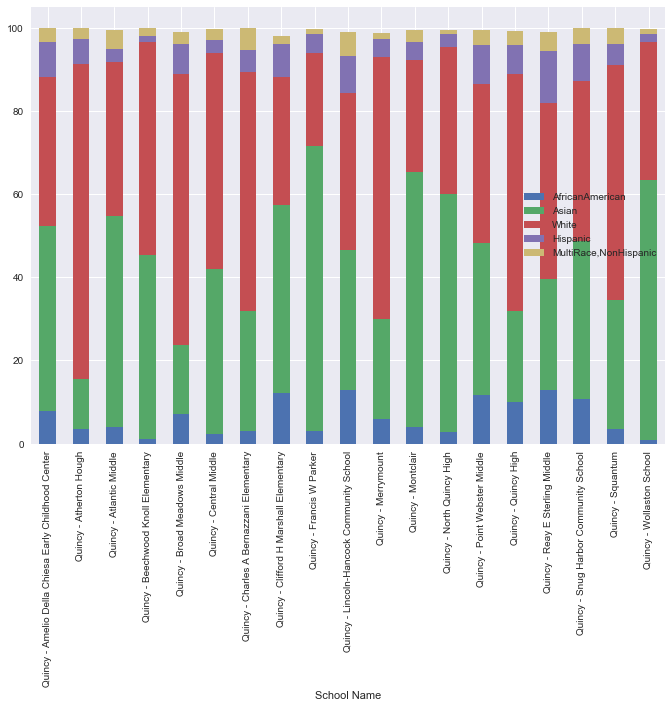

In [146]:
ax = quincy[['AfricanAmerican','Asian','White','Hispanic','MultiRace,NonHispanic']].plot.bar(stacked=True, figsize=(len(quincy) *0.5,10))
fig = ax.get_figure()
fig.tight_layout()

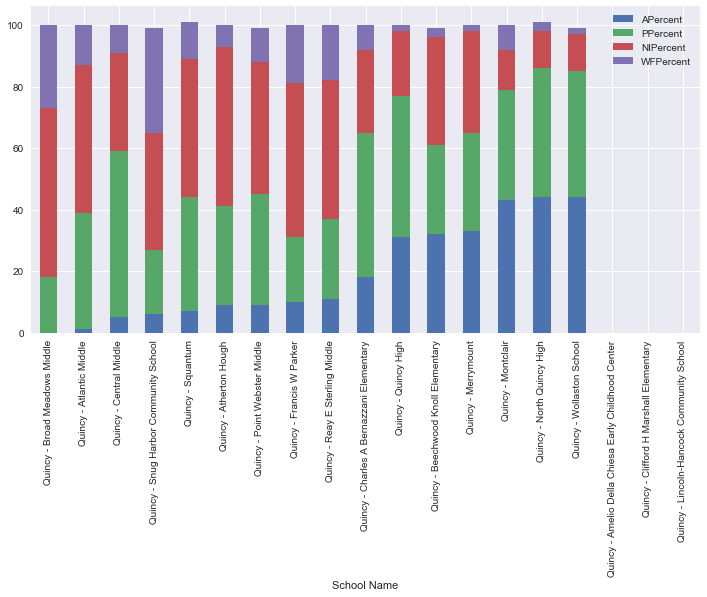

In [147]:
quincy[['APercent', 'PPercent', 'NIPercent', 'WFPercent']].sort_values('APercent').plot.bar(stacked=True, figsize=(12, 6))

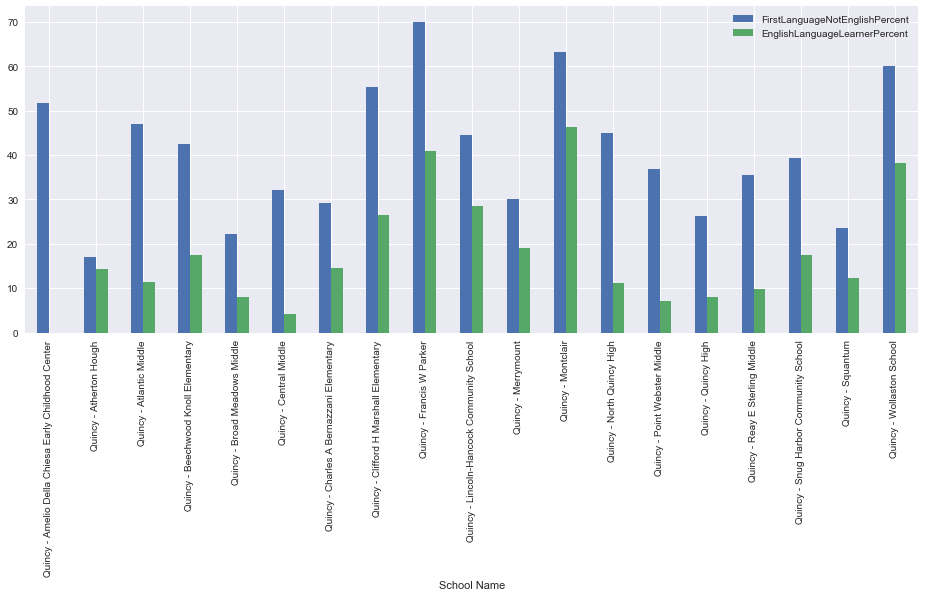

In [148]:
quincy[['FirstLanguageNotEnglishPercent', 
       'EnglishLanguageLearnerPercent', 
       ]].plot.bar(stacked=False, figsize=(16, 6))

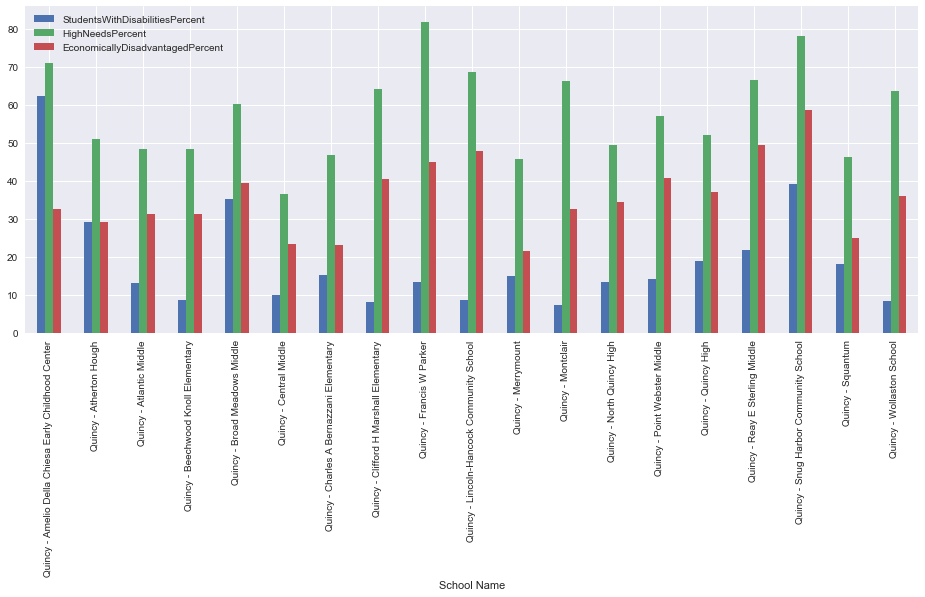

In [149]:
quincy[['StudentsWithDisabilitiesPercent', 'HighNeedsPercent',
        'EconomicallyDisadvantagedPercent']].plot.bar(stacked=False, figsize=(16, 6))


# The Diverse Elite
Now Join up with some basic income data and filter way down.  This is pretty arbitrary to cut at 60. 

In [150]:

diverse_elite = districts.query("White < 60 & Hispanic < 60 & AfricanAmerican < 60 & Asian < 60 & AttendingCollUnivPercent > 60 & EconomicallyDisadvantagedPercent > 10")
print(len(diverse_elite))
show_cols = ["White",
             "Hispanic",
             "AfricanAmerican",
             "Asian",
             "AttendingCollUnivPercent",
             "AttendingCollUnivNum",
             "EconomicallyDisadvantagedPercent",
             "P+APercent",
             'Population',]  # Percent Advanced or Proficient according to MCAS
diverse_elite[show_cols].sort_values('AttendingCollUnivPercent', ascending=False)

26


,White,Hispanic,AfricanAmerican,Asian,AttendingCollUnivPercent,AttendingCollUnivNum,EconomicallyDisadvantagedPercent,P+APercent,Population
District Name,,,,,,,,,
Avon,54.1,8.0,28.5,4.4,87.8,36.0,23.4,39.0,"4,400"
Stoughton,56.1,10.8,21.5,6.3,83.3,184.0,26.8,52.0,"27,522"
Amherst-Pelham,58.2,16.2,7.1,9.2,83.1,206.0,22.4,73.0,NaN
Cambridge,39.9,13.7,25.2,12.4,80.6,354.0,28.1,56.0,"105,737"
Methuen,50.5,39.4,1.2,3.8,77.6,326.0,31.7,42.0,"47,690"
Lowell,27.4,31.9,7.9,28.9,76.9,450.0,52.3,28.0,"107,466"
Malden,29.3,23.2,19.5,23.7,75.9,330.0,41.3,42.0,"59,803"
Marlborough,43.4,46.8,3.4,3.7,75.8,191.0,31.7,43.0,"38,842"
Quincy,45.1,5.8,6.6,39.0,74.3,510.0,34.2,57.0,"92,595"


In [151]:
list(districts.columns)

['PK',
 'K',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 'SP',
 'Total',
 'AfricanAmerican',
 'Asian',
 'Hispanic',
 'White',
 'NativeAmerican',
 'NativeHawaiian,PacificIslander',
 'MultiRace,NonHispanic',
 'Males',
 'Females',
 'TestsTakers',
 'TestsTaken',
 'OneTest',
 'TwoTests',
 'ThreeTests',
 'FourTests',
 'FiveorMoreTests',
 'Unnamed:9',
 'Score=1',
 'Score=2',
 'Score=3',
 'Score=4',
 'Score=5',
 'PercentScore12',
 'PercentScore35',
 'TotalNumofClasses',
 'AverageClassSize',
 'NumberofStudents',
 'FemalePercent',
 'MalePercent',
 'EnglishLanguageLearnerPercent',
 'StudentswithDisabilitiesPercent',
 'EconomicallyDisadvantagedPercent',
 'NumEnrolledGrades09through12',
 'NumDropoutAllGrades',
 'PercentDropoutAllGrades',
 'PercentDropoutGrade09',
 'PercentDropoutGrade10',
 'PercentDropoutGrade11',
 'PercentDropoutGrade12',
 'NuminCohort',
 'PercentGraduated',
 'PercentStillinSchool',
 'PercentNonGradCompleters',
 'PercentHSEquiv',
 'PercentDroppedOut

/Users/tim/miniconda3/envs/dd/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


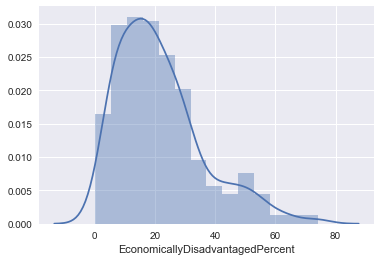

In [211]:
sns.distplot(districts['EconomicallyDisadvantagedPercent'].dropna())

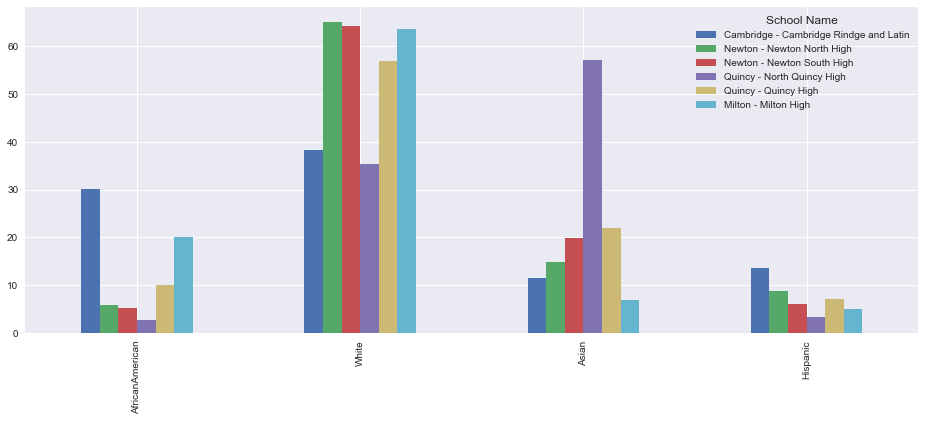

In [153]:
newton = town("Newton")
milton = town("Milton")
cambridge = town("Cambridge")

compare = pd.concat([
cambridge[cambridge.index.str.contains("Latin")],
newton[newton.index.str.contains("High")],
quincy[quincy.index.str.contains("High")],
milton[milton.index.str.contains("High")],
])


compare[["AfricanAmerican", "White", "Asian", "Hispanic"]].transpose().plot.bar(stacked=False, figsize=(16, 6))


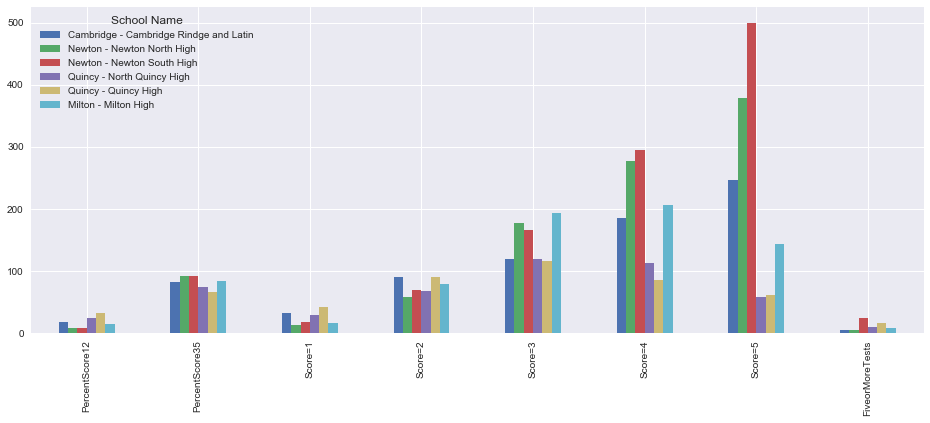

In [156]:
compare[['PercentScore12',
 'PercentScore35', 'Score=1','Score=2','Score=3','Score=4','Score=5',
 'FiveorMoreTests',]].transpose().plot.bar(stacked=False, figsize=(16, 6))

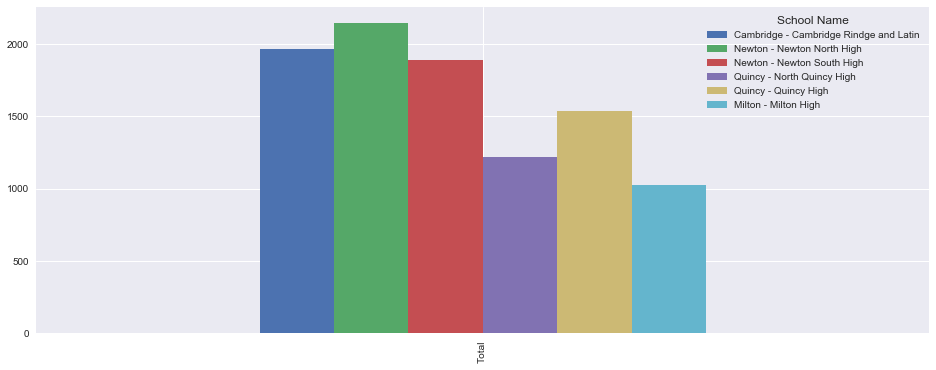

In [157]:
compare[["Total"]].transpose().plot.bar(stacked=False, figsize=(16, 6))

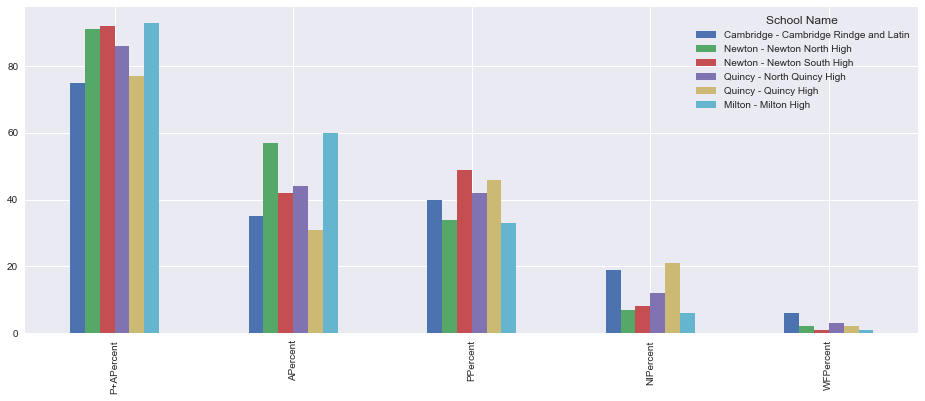

In [158]:
compare[[
 'P+APercent',
 'APercent',
 'PPercent',
 'NIPercent',
 'WFPercent',]].transpose().plot.bar(stacked=False, figsize=(16, 6))

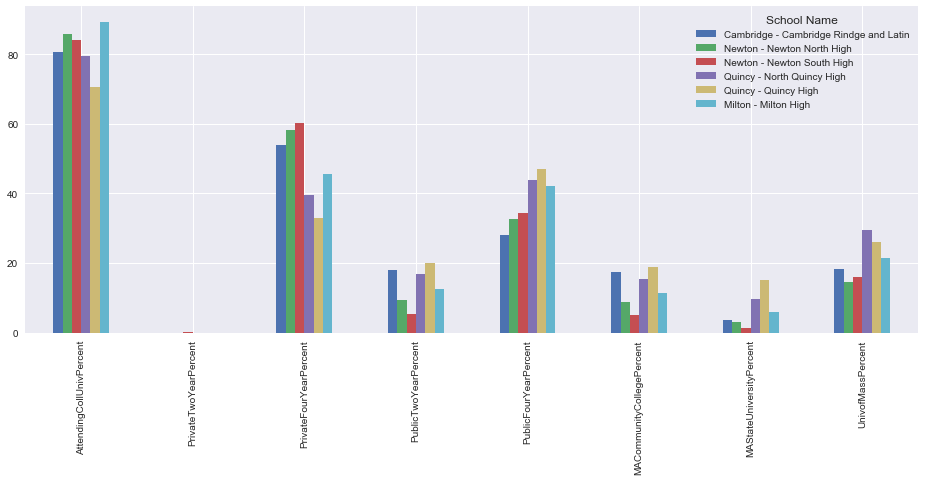

In [159]:
compare[['AttendingCollUnivPercent',
 'PrivateTwoYearPercent',
 'PrivateFourYearPercent',
 'PublicTwoYearPercent',
 'PublicFourYearPercent',
 'MACommunityCollegePercent',
 'MAStateUniversityPercent',
 'UnivofMassPercent',]].transpose().plot.bar(stacked=False, figsize=(16, 6))


TypeError: Empty 'DataFrame': no numeric data to plot

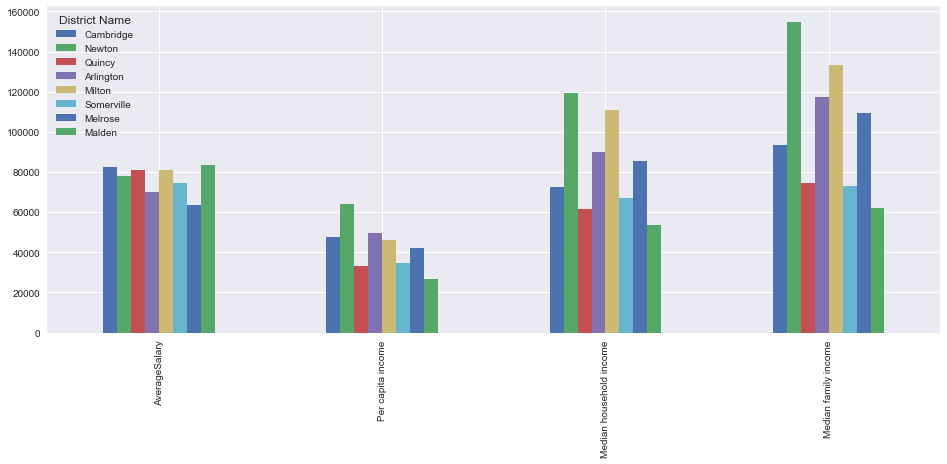

In [160]:

money = districts.loc[["Cambridge", "Newton", "Quincy", "Arlington", "Milton", "Somerville", "Melrose", "Malden"]][[
 'AverageSalary',
 'Per capita income',
 'Median household income',
 'Median family income',]].replace({'\$': '', ',': ''}, regex=True).astype(float).transpose()
money.plot.bar(stacked=False, figsize=(16, 6))


In [220]:
distance = lambda column1, column2: pd.np.linalg.norm(column1 - column2)
towns = districts.loc[["Cambridge", "Belmont", "Brookline", "Boston", "Newton", "Quincy", "Arlington", "Milton", "Somerville", "Melrose", "Malden"]]
towns = towns.replace({'\$': '', ',': ''}, regex=True).transpose()
townsfloat = towns.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

townsfloatscaled = townsfloat / pd.np.max(townsfloat, axis=0)
df = townsfloatscaled.apply(lambda col1: townsfloatscaled.apply(lambda col2: distance(col1, col2)))

sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=False)


ValueError: zero-size array to reduction operation minimum which has no identity

In [225]:
districts['TotalExpendituresperPupil']
    

District Name
Abington                                 $14,046.97
Acton-Boxborough                         $14,745.20
Acushnet                                 $12,119.53
Adams-Cheshire                           $13,483.06
Agawam                                   $15,533.31
Amesbury                                 $14,580.21
Amherst                                  $20,895.32
Amherst-Pelham                           $20,504.02
Andover                                  $16,388.72
Arlington                                $13,984.11
Ashburnham-Westminster                   $12,713.48
Ashland                                  $13,091.58
Athol-Royalston                          $14,027.68
Attleboro                                $13,377.56
Auburn                                   $13,371.14
Avon                                     $14,743.98
Ayer Shirley School District             $14,090.09
Barnstable                               $15,555.88
Bedford                                  $18,119.8